In [ ]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)



Mounted at /content/drive/


**IMPORTING IMAGE**

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x320 at 0x7A213F119780>


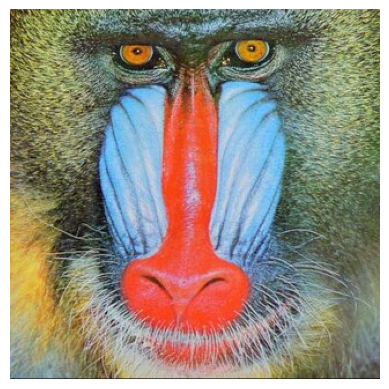

[[119  51  98 ... 103 136 162]
 [ 91  58  69 ... 123  98  94]
 [117 104  64 ...  79  63  74]
 ...
 [114 140 145 ...  93  87  80]
 [142 148 141 ...  98  94  88]
 [ 72  60  46 ...  34  30  26]]
(320, 320)
Image format: None
Image mode: L
Image size: (320, 320)


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Open an image file
# folder_path = '/content/drive/My Drive/IT352_MiniProject/images/'

# List contents of the folder
# !ls "$folder_path"
# image = Image.open(folder_path +"Baboon.jpg")

image = Image.open('/content/drive/MyDrive/Copy of Baboon.jpg')

grayscale_image = image.convert("L")

print(image)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

image = image.convert('L')

pixel_values = np.array(image)
P = np.vstack(pixel_values)

print(P)
print(P.shape)


print("Image format:", image.format)
print("Image mode:", image.mode)
print("Image size:", image.size)
M, N = image.size
if M % 2 != 0:
    M += 1
if N % 2 != 0:
    N += 1
image = image.resize((M, N))

M=image.size[0]
N = image.size[1]

**SECRET KEY GENERATION**

In [ ]:
import math
import numpy as np

def rotate_matrix_180(matrix):
    reversed_matrix = [row[::-1] for row in matrix[::-1]]
    return reversed_matrix
def pwlcg_iteration(x, p):
    if 0 <= x < p:
        return x/p
    elif p <= x < 0.5:
        return (x - p) / (0.5 - p)
    else:
        return pwlcg_iteration(1-x,p)


def generate_initial_values_and_parameters(secret_key):
    k1k8 = secret_key[:8]
    k9k16 = secret_key[8:16]



    x00 = 0.8 * sum(int(ki, 16)/ (2**(4*i)) for i, ki in enumerate(k1k8, start=1)) + 0.1
    # print(x00)

    p0 = 0.4 * sum((int(ki, 16)) / (2**(4*i)) for i, ki in enumerate(k9k16, start=1)) + 0.1
    # print(p0)

    return x00, p0

def main(secret_key,M,N):
    d = len(secret_key) // 16
    x00, p0 = generate_initial_values_and_parameters(secret_key)

    for i in range(64):
      x00 = pwlcg_iteration(x00, p0)


    if d > 1:
        for j in range(1, d):
            k1k8 = secret_key[16*j : 16*j +8]
            k9k16 = secret_key[16*j +8 : 16*j +16]


            x0j = 0.8 * sum(int(ki, 16)/ (2**(4*i)) for i, ki in enumerate(k1k8, start=1)) + 0.1
            x0j = 0.382 * x0j +0.618*x00

            pj = 0.4 * sum((int(ki, 16)) / (2**(4*i)) for i, ki in enumerate(k9k16, start=1)) + 0.1
            pj = 0.382 * pj + 0.618 * p0

            for _ in range(64):
                x0j = pwlcg_iteration(x0j, pj)

            x00 = x0j

    print(f"Final x0: {x00}, Final p: {p0}")

    x0=pwlcg_iteration(x00, p0)
    Y = np.zeros((M, N))
    for i in range(M):
      for j in range(N):
        x0=pwlcg_iteration(x0, p0)
        Y[i][j]=x0
#     print(Y)
    X = np.zeros((M, N))
    for i in range(M):
      for j in range(N):
        X[i][j]=math.floor(Y[i][j]*(10**14))%256

    return X

import secrets
def generate_hex_key(size):
    num_bytes = size // 8
    if size % 8 != 0:
        num_bytes += 1

    random_bytes = secrets.token_bytes(num_bytes)

    hex_key = random_bytes.hex()

    hex_key = hex_key[:size//4]

    hex_key = hex_key.upper()

    return hex_key



**FORWARD DIFFUSION**

In [ ]:
def forward_diffusion_algorithm(P, X):
    M = len(P)
    N = len(P[0])
    A = [[0] * N for _ in range(M)]

    i = 0
    j = 0
    A[i][j] = (P[i][j] + X[i][j]) % 256
    j += 1

    while j <= N - 1:
        A[i][j] = (P[i][j] + A[i][j - 1] + X[i][j]) % 256
        j += 1

    while j > N - 1:
        j = 0
        i += 1
        A[i][j] = (P[i][j] + A[i - 1][j] + A[i - 1][N - 1] + X[i][j]) % 256
        j += 1

        while j <= N - 1:
            A[i][j] = (P[i][j] + A[i - 1][j] + A[i][j - 1] + X[i][j]) % 256

            if i == M - 1 and j == N - 1:
                break
            j += 1

    return A




**PLAINTEXT SCRAMBLING**

In [ ]:
def plaintext_scrambling(B):
    M, N = B.shape
    D = np.copy(B)

    for i in range(M):
        for j in range(N):
            Ri = np.sum(B[i, :]) - B[i, j]
            Hj = np.sum(B[:, j]) - B[i, j]

            if j % 2 == 0:
                m = (Hj % M)
                n = (Ri % N)
            else:
                m = M - (Hj % M)-1
                n = N - (Ri % N)-1
            m=int(m)
            n=int(n)
            if m== i and n == j:
                D[i, j], D[m, n] = D[m, n], D[i, j]

    return D


**BACKWARD DIFFUSION**

In [ ]:

def backward_diffusion_algorithm(E, Z):
    M = len(E)
    N = len(E[0])
    F = [[0] * N for _ in range(M)]
    i, j = 0, 0

    while i < M:
        while j < N:
            if j == N - 1:
                F[i][j] = (256 * 3 + E[i][j] - E[(i + 1) % M][N - 1] - E[(i + 1) % M][0] - Z[i][j]) % 256
            else:
                F[i][j] = (256 * 3 + E[i][j] - E[i][j + 1] - E[(i + 1) % M][j] - Z[i][j]) % 256
            j += 1

        j = 0
        i += 1



        if i == M - 1:
            while j < N:
                if j == N - 1:
                    F[i][j] = (256 + E[i][j] - Z[i][j]) % 256
                else:
                    F[i][j] = (256 * 2 + E[i][j] - E[M - 1][(j + 1) % N] - Z[i][j]) % 256
                j += 1

    return F



**ENCRYPTION**

In [ ]:
P1 = P
M=len(P)
N=len(P[0])
print("Matrix P")
print(P)
print()

# secret_key = generate_hex_key(64*2)
# print("Secret Key")
# print(secret_key)
# print()

secret_key = 'FEDCBA98765432100123456789ABCDEF02468ACE13579BDFF0E1D2C3B4A59687'
X=main(secret_key,M,N)
X=np.array(X)
print()
print("Matrix X")
print(X)
print()

Z=rotate_matrix_180(X)
Z=np.array(Z)
print("Matrix Z")
print(Z)
print()

A = forward_diffusion_algorithm(P1, X)
A=np.array(A)
print("Matrix A")
print(A)
print()

B = rotate_matrix_180(A)
B = np.array(B)
print("Matrix B")
print(B)
print()

D = plaintext_scrambling(B)
D=np.array(D)
print("Matrix D")
print(D)
print()

E=rotate_matrix_180(D)
E=np.array(E)
print("Matrix E")
print(E)
print()

F=backward_diffusion_algorithm(E, Z)
F=np.array(F).reshape(M,N)
print("Matrix F")
print(F)
print()

C=rotate_matrix_180(F)
C=np.array(C).reshape(M,N)
print("Matrix C")
print(C)



Matrix P
[[119  51  98 ... 103 136 162]
 [ 91  58  69 ... 123  98  94]
 [117 104  64 ...  79  63  74]
 ...
 [114 140 145 ...  93  87  80]
 [142 148 141 ...  98  94  88]
 [ 72  60  46 ...  34  30  26]]

Final x0: 0.8389515400424271, Final p: 0.28488888889551167

Matrix X
[[182.  77.  14. ... 150.  38. 242.]
 [145.  56. 121. ... 127.  81. 235.]
 [138. 101.  50. ... 160.  39. 162.]
 ...
 [ 81. 165.  68. ... 160. 187. 208.]
 [149.  33. 122. ...  75. 209. 160.]
 [ 14. 146. 155. ...  17.  31. 146.]]

Matrix Z
[[146.  31.  17. ... 155. 146.  14.]
 [160. 209.  75. ... 122.  33. 149.]
 [208. 187. 160. ...  68. 165.  81.]
 ...
 [162.  39. 160. ...  50. 101. 138.]
 [235.  81. 127. ... 121.  56. 145.]
 [242.  38. 150. ...  14.  77. 182.]]

Matrix A
[[ 45. 173.  29. ...  74. 248. 140.]
 [165. 196. 159. ...   1. 172. 129.]
 [ 37. 182. 199. ...  87. 105. 214.]
 ...
 [171. 183. 187. ... 249. 252. 196.]
 [146. 254. 192. ... 131. 174. 106.]
 [ 82.  30. 167. ... 144. 123. 145.]]

Matrix B
[[145. 123. 144

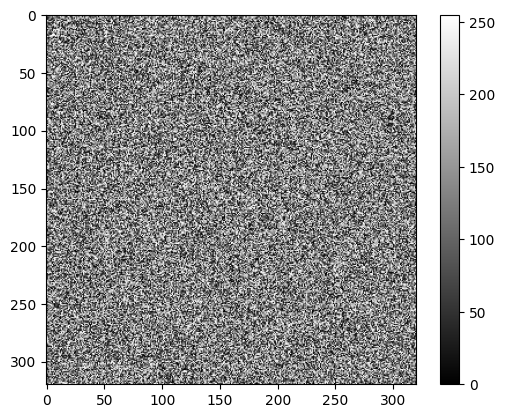

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(C, cmap='gray')
plt.colorbar()
plt.show()


**DECRYPTION**

In [ ]:
A_d=forward_diffusion_algorithm(C, X)
B_d=rotate_matrix_180(A_d)
B_d = np.array(B_d)
D_d=plaintext_scrambling(B_d)
D_d=np.array(D_d)
E_d=rotate_matrix_180(D_d)
E_d=np.array(E_d)
F_d=backward_diffusion_algorithm(E_d, Z)
F_d=np.array(F_d).reshape(M,N)
P_dec=rotate_matrix_180(F_d)
P_dec=np.array(P_dec)
print(P_dec)

[[119.  51.  98. ... 103. 136. 162.]
 [ 91.  58.  69. ... 123.  98.  94.]
 [117. 104.  64. ...  79.  63.  74.]
 ...
 [114. 140. 145. ...  93.  87.  80.]
 [142. 148. 141. ...  98.  94.  88.]
 [ 72.  60.  46. ...  34.  30.  26.]]


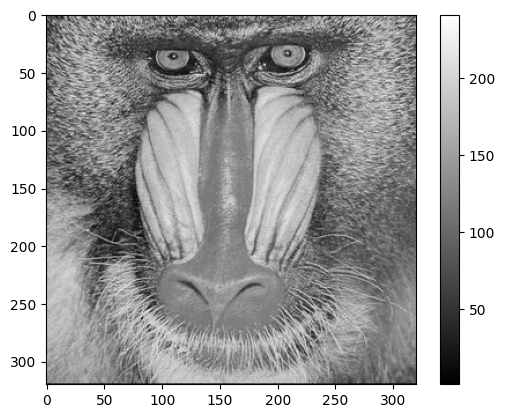

In [ ]:
plt.imshow(P_dec, cmap='gray')
plt.colorbar()
plt.show()

In [ ]:
def NPCR(pixel_data1, pixel_data2,num_pixels):

    M,N=pixel_data1.shape
    sum=0
    for i in range(M):
      for j in range(N):
          sum+=abs(np.sign(pixel_data1[i,j]-pixel_data2[i,j]))
    sum/=(M*N)

    return sum*100






In [ ]:
def UACI(pixel_data1, pixel_data2,num_pixels):

    M,N=pixel_data1.shape
    sum=0
    for i in range(M):
      for j in range(N):
          sum+=abs(pixel_data1[i,j]-pixel_data2[i,j])/255
    sum/=(M*N)

    return sum*100

**KEY SENSITIVITY ANALYSIS CASE 1**

Final x0: 0.983182868078214, Final p: 0.28488888889551167


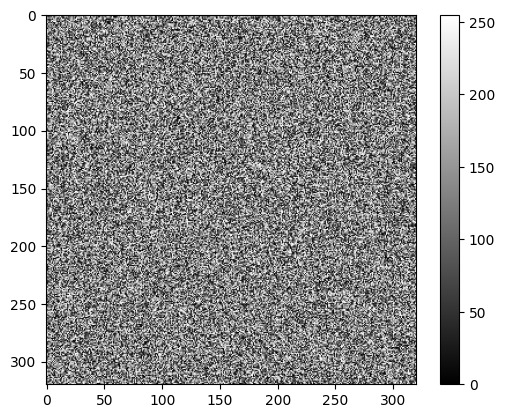

In [ ]:
secret_key = 'FEDCBA98765432100123456789ABCDEF02468ACE13579BDFF0E1D2C3B4A59686'
X_2=main(secret_key,M,N)

Z_2=rotate_matrix_180(X_2)
Z_2 = np.array(Z_2)

A_2 = forward_diffusion_algorithm(P, X_2)
A_2=np.array(A_2)

B_2 = rotate_matrix_180(A_2)
B_2 = np.array(B_2)

D_2 = plaintext_scrambling(B_2)

D_2=np.array(D_2)
E_2=rotate_matrix_180(D_2)
E_2=np.array(E_2)

F_2=backward_diffusion_algorithm(E_2, Z_2)

F_2=np.array(F_2).reshape(M,N)
C_2=rotate_matrix_180(F_2)
C_2=np.array(C_2).reshape(M,N)


plt.imshow(C_2, cmap='gray')
plt.colorbar()
plt.show()

In [ ]:
NPCR1=NPCR(C,C_2,M*N)
print("NPCR:")
print(NPCR1)
UACI1=UACI(C,C_2,M*N)
print()
print("UACI: ")
print(UACI1)

NPCR:
99.5947265625

UACI: 
33.4412913603046


**KEY SENSITIVITY ANALYSIS CASE 2**

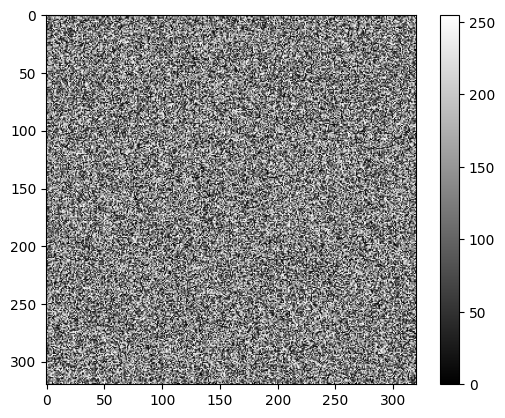

In [ ]:
A_d_2=forward_diffusion_algorithm(C, X_2)
A_d_2=np.array(A_d_2)

B_d_2=rotate_matrix_180(A_d_2)
B_d_2=np.array(B_d_2)

D_d_2=plaintext_scrambling(B_d_2)
D_d_2=np.array(D_d_2)

E_d_2=rotate_matrix_180(D_d_2)
E_d_2=np.array(E_d_2)

F_d_2=backward_diffusion_algorithm(E_d_2, Z_2)
F_d_2=np.array(F_d_2).reshape(M,N)

P_dec_2=rotate_matrix_180(F_d_2)
P_dec_2=np.array(P_dec_2)


plt.imshow(P_dec_2, cmap='gray')
plt.colorbar()
plt.show()


In [ ]:

print("NPCR")
print(NPCR(P,P_dec_2,M*N))
print()
print("UACI:")
print(UACI(P,P_dec_2,M*N))

NPCR
99.5947265625

UACI:
27.520465686287


**PLAINTEXT SENSITIVITY ANALYSIS**

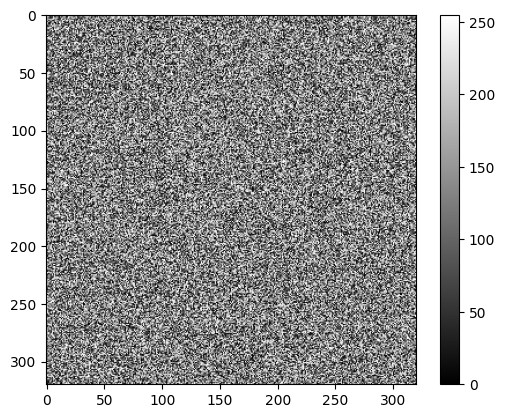

In [ ]:
P2=np.copy(P)
P2[0,0]+=1


A_2 = forward_diffusion_algorithm(P2, X)
A_2=np.array(A_2)

B_2 = rotate_matrix_180(A_2)
B_2 = np.array(B_2)

D_2 = plaintext_scrambling(B_2)

D=np.array(D_2)
E_2=rotate_matrix_180(D_2)
E_2=np.array(E_2)

F_2=backward_diffusion_algorithm(E_2, Z_2)
F_2=np.array(F_2).reshape(M,N)

C_2=rotate_matrix_180(F_2)
C_2=np.array(C_2).reshape(M,N)


plt.imshow(C_2, cmap='gray')
plt.colorbar()
plt.show()

In [ ]:
print("NPCR: ")
print(NPCR(C,C_2,M*N))
print()
print("UACI: ")
print(UACI(C,C_2,M*N))

NPCR: 
99.6025390625

UACI: 
33.378423713245844


**CIPHERTEXT SENSITIVITY ANALYSIS CASE 1**

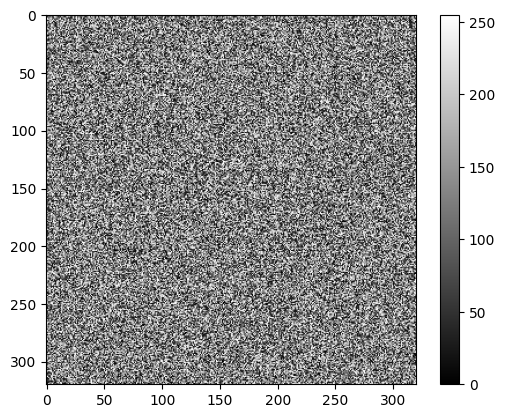

In [ ]:
C2=np.copy(C)
C2[0,0]=C2[0,0]+1

A_d_2=forward_diffusion_algorithm(C2, X)
A_d_2=np.array(A_d_2)


B_d_2=rotate_matrix_180(A_d_2)
B_d_2=np.array(B_d_2)

D_d_2=plaintext_scrambling(B_d_2)
D_d_2=np.array(D_d_2)

E_d_2=rotate_matrix_180(D_d_2)
E_d_2=np.array(E_d_2)

F_d_2=backward_diffusion_algorithm(E_d_2, Z_2)
F_d_2=np.array(F_d_2).reshape(M,N)

P_dec_2=rotate_matrix_180(F_d_2)
P_dec_2=np.array(P_dec_2)

plt.imshow(P_dec_2, cmap='gray')
plt.colorbar()
plt.show()



In [ ]:

print("NPCR:")
NPCR1=NPCR(P,P_dec_2,M*N)
print(NPCR1)
print()

print("UACI: ")
UACI1=UACI(P,P_dec_2,M*N)
print(UACI1)

NPCR:
99.6025390625

UACI: 
27.492555147071236


**CIPHERTEXT SENSITIVITY ANALYSIS CASE 2**

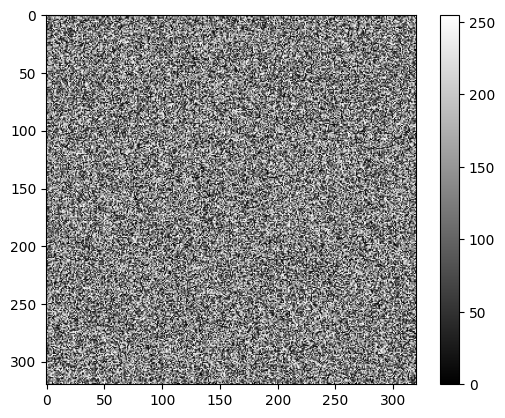

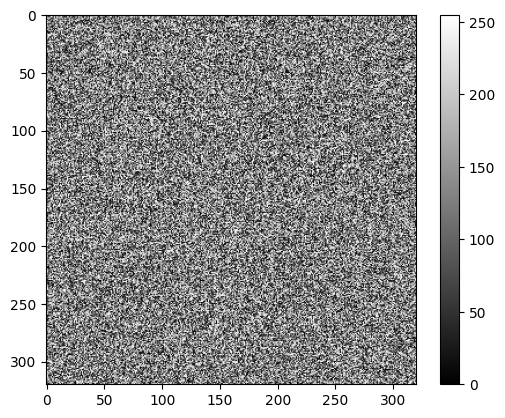

In [ ]:
C2=np.copy(C)

C2[0,0]=C2[0,0]+1


A_d_2=forward_diffusion_algorithm(C, X_2)

A_d_2=np.array(A_d_2)



B_d_2=rotate_matrix_180(A_d_2)
B_d_2=np.array(B_d_2)


D_d_2=plaintext_scrambling(B_d_2)
D_d_2=np.array(D_d_2)

E_d_2=rotate_matrix_180(D_d_2)
E_d_2=np.array(E_d_2)


F_d_2=backward_diffusion_algorithm(E_d_2, Z_2)
F_d_2=np.array(F_d_2).reshape(M,N)

P3=rotate_matrix_180(F_d_2)
P3=np.array(P3)


plt.imshow(P3, cmap='gray')
plt.colorbar()
plt.show()


A_d_2=forward_diffusion_algorithm(C2, X_2)
A_d_2=np.array(A_d_2)


B_d_2=rotate_matrix_180(A_d_2)
B_d_2=np.array(B_d_2)


D_d_2=plaintext_scrambling(B_d_2)
D_d_2=np.array(D_d_2)

E_d_2=rotate_matrix_180(D_d_2)
E_d_2=np.array(E_d_2)


F_d_2=backward_diffusion_algorithm(E_d_2, Z_2)
F_d_2=np.array(F_d_2).reshape(M,N)

P4=rotate_matrix_180(F_d_2)
P4=np.array(P4)


plt.imshow(P4, cmap='gray')
plt.colorbar()
plt.show()



In [ ]:

print("NPCR: ")
print(NPCR(P3,P4,M*N))
print()
print("UACI:")
print(UACI(P3,P4,M*N))

NPCR: 
98.3740234375

UACI:
33.554610906861846


**INFORMATION ENTROPY**

In [ ]:
import numpy as np

def entropy(image):

    img_array = np.array(image)
    flat_array = img_array.flatten()

    hist, _ = np.histogram(flat_array, bins=range(257))

    prob_dist = hist / flat_array.size

    entropy_val = -np.sum(prob_dist[prob_dist > 0] * np.log2(prob_dist[prob_dist > 0]))

    return entropy_val


entropy_val = entropy(image)
print("Entropy of Plain Image:", entropy_val)

matrix_array = np.array(C, dtype=np.uint8)
img = Image.fromarray(matrix_array)

entropy_val = entropy(img)
print("Entropy of Cipher Image:", entropy_val)


Entropy of Plain Image: 7.300381907690502
Entropy of Cipher Image: 7.998215399143521


**VERTICAL CORRELATION OF PLAIN IMAGE**

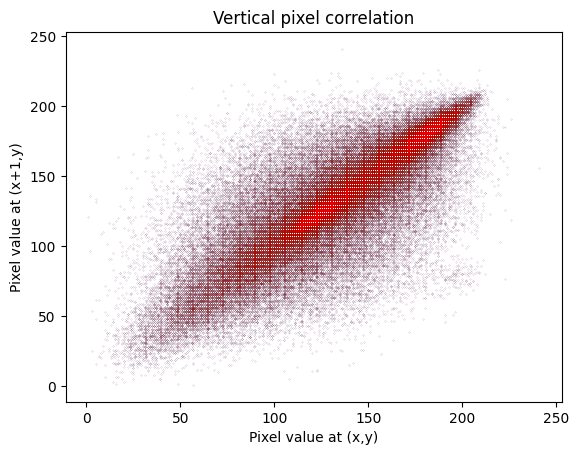

Vertical correlation coefficient:  0.7758238895451623


In [ ]:
coeff = []
im=np.copy(P)
x0 = im[:-1,:]
y0 = im[1:,:]
plt.scatter(x0, y0, s=0.01, alpha=0.3, color='b')
coeff.append(np.corrcoef(x0.flat, y0.flat)[0,1])

x1 = im[:-1,:]
y1 = im[1:,:]
plt.scatter(x1, y1, s=0.01, alpha=0.3, color='g')
coeff.append(np.corrcoef(x1.flat, y1.flat)[0,1])

x2 = im[:-1,:]
y2 = im[1:,:]
plt.scatter(x2, y2, s=0.01, alpha=0.3, color='r')
coeff.append(np.corrcoef(x2.flat, y2.flat)[0,1])

plt.title('Vertical pixel correlation')
plt.xlabel('Pixel value at (x,y)')
plt.ylabel('Pixel value at (x+1,y)')
plt.show()

print('Vertical correlation coefficient: ', np.mean(coeff))

**VERTICAL CORRELATION OF CIPHER IMAGE**

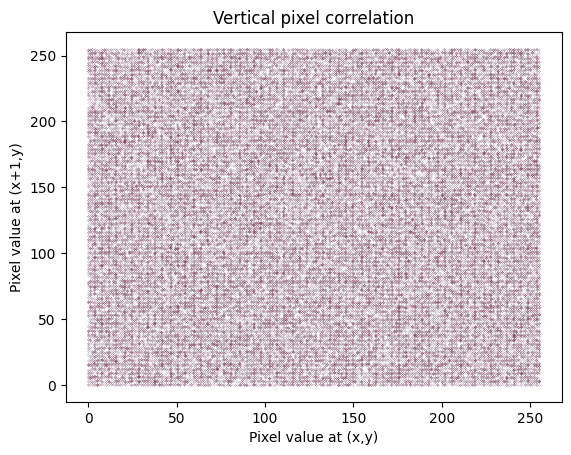

Vertical correlation coefficient:  -0.0006164343276394374


In [ ]:
coeff = []
im=np.copy(C)
x0 = im[:-1,:]
y0 = im[1:,:]
plt.scatter(x0, y0, s=0.01, alpha=0.3, color='b')
coeff.append(np.corrcoef(x0.flat, y0.flat)[0,1])

x1 = im[:-1,:]
y1 = im[1:,:]
plt.scatter(x1, y1, s=0.01, alpha=0.3, color='g')
coeff.append(np.corrcoef(x1.flat, y1.flat)[0,1])

x2 = im[:-1,:]
y2 = im[1:,:]
plt.scatter(x2, y2, s=0.01, alpha=0.3, color='r')
coeff.append(np.corrcoef(x2.flat, y2.flat)[0,1])

plt.title('Vertical pixel correlation')
plt.xlabel('Pixel value at (x,y)')
plt.ylabel('Pixel value at (x+1,y)')
plt.show()

print('Vertical correlation coefficient: ', np.mean(coeff))

**DIAGONAL CORRELATION OF PLAIN IMAGE**

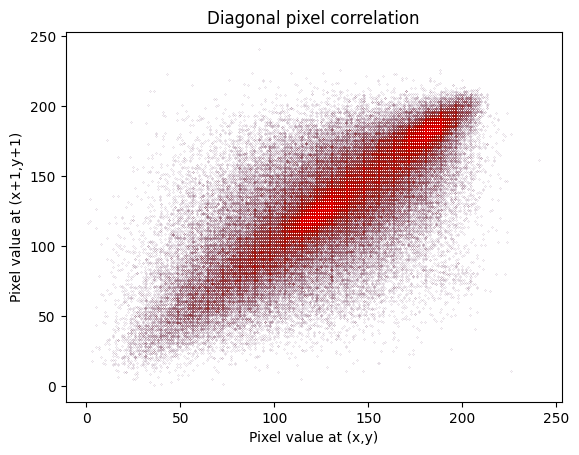

Diagonal correlation coefficient:  0.7366032647194022


In [ ]:
coeff = []
im=np.copy(P)
x0 = im[:-1,:-1]
y0 = im[1:,1:]
plt.scatter(x0, y0, s=0.01, alpha=0.3, color='b')
coeff.append(np.corrcoef(x0.flat, y0.flat)[0,1])

x1 = im[:-1,:-1]
y1 = im[1:,1:]
plt.scatter(x1, y1, s=0.01, alpha=0.3, color='g')
coeff.append(np.corrcoef(x1.flat, y1.flat)[0,1])

x2 = im[:-1,:-1]
y2 = im[1:,1:]
plt.scatter(x2, y2, s=0.01, alpha=0.3, color='r')
coeff.append(np.corrcoef(x2.flat, y2.flat)[0,1])

plt.title('Diagonal pixel correlation')
plt.xlabel('Pixel value at (x,y)')
plt.ylabel('Pixel value at (x+1,y+1)')
plt.show()

print('Diagonal correlation coefficient: ', np.mean(coeff))

**DIAGONAL CORRELATION OF CIPHER IMAGE**

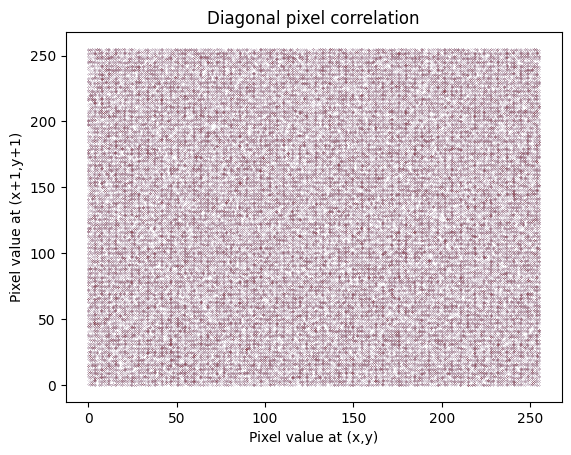

Diagonal correlation coefficient:  0.0022649201846259054


In [ ]:
coeff = []
im=np.copy(C)
x0 = im[:-1,:-1]
y0 = im[1:,1:]
plt.scatter(x0, y0, s=0.01, alpha=0.3, color='b')
coeff.append(np.corrcoef(x0.flat, y0.flat)[0,1])

x1 = im[:-1,:-1]
y1 = im[1:,1:]
plt.scatter(x1, y1, s=0.01, alpha=0.3, color='g')
coeff.append(np.corrcoef(x1.flat, y1.flat)[0,1])

x2 = im[:-1,:-1]
y2 = im[1:,1:]
plt.scatter(x2, y2, s=0.01, alpha=0.3, color='r')
coeff.append(np.corrcoef(x2.flat, y2.flat)[0,1])

plt.title('Diagonal pixel correlation')
plt.xlabel('Pixel value at (x,y)')
plt.ylabel('Pixel value at (x+1,y+1)')
plt.show()

print('Diagonal correlation coefficient: ', np.mean(coeff))

**HORIZONTAL CORRELATION OF PLAIN IMAGE**

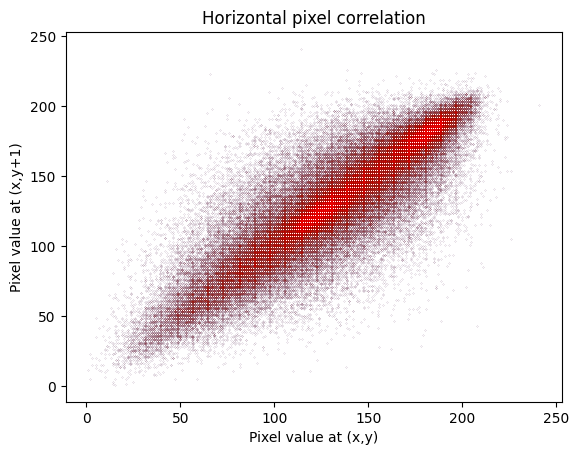

Horizontal correlation coefficient:  0.8459696511902844


In [ ]:
coeff = []
im=np.copy(P)
x0 = im[:,:-1]
y0 = im[:,1:]
plt.scatter(x0, y0, s=0.01, alpha=0.3, color='b')
coeff.append(np.corrcoef(x0.flat, y0.flat)[0,1])

x1 = im[:,:-1]
y1 = im[:,1:]
plt.scatter(x1, y1, s=0.01, alpha=0.3, color='g')
coeff.append(np.corrcoef(x1.flat, y1.flat)[0,1])

x2 = im[:,:-1]
y2 = im[:,1:]
plt.scatter(x2, y2, s=0.01, alpha=0.3, color='r')
coeff.append(np.corrcoef(x2.flat, y2.flat)[0,1])

plt.title('Horizontal pixel correlation')
plt.xlabel('Pixel value at (x,y)')
plt.ylabel('Pixel value at (x,y+1)')
plt.show()

print('Horizontal correlation coefficient: ', np.mean(coeff))

**HORIZONTAL CORRELATION OF CIPHER IMAGE**

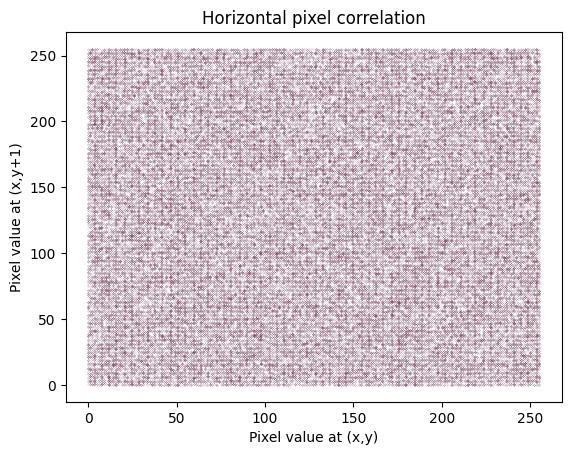

Horizontal correlation coefficient:  -0.0005565229064104836


In [ ]:
coeff = []
im=np.copy(C)
x0 = im[:,:-1]
y0 = im[:,1:]
plt.scatter(x0, y0, s=0.01, alpha=0.3, color='b')
coeff.append(np.corrcoef(x0.flat, y0.flat)[0,1])

x1 = im[:,:-1]
y1 = im[:,1:]
plt.scatter(x1, y1, s=0.01, alpha=0.3, color='g')
coeff.append(np.corrcoef(x1.flat, y1.flat)[0,1])

x2 = im[:,:-1]
y2 = im[:,1:]
plt.scatter(x2, y2, s=0.01, alpha=0.3, color='r')
coeff.append(np.corrcoef(x2.flat, y2.flat)[0,1])

plt.title('Horizontal pixel correlation')
plt.xlabel('Pixel value at (x,y)')
plt.ylabel('Pixel value at (x,y+1)')
plt.show()

print('Horizontal correlation coefficient: ', np.mean(coeff))

**SPEED COMPARISION FOR DIFFERENT KEY SIZE**

In [ ]:
import secrets
# Random key generation of required size
def generate_hex_key(size):
    num_bytes = size // 8
    if size % 8 != 0:
        num_bytes += 1

    random_bytes = secrets.token_bytes(num_bytes)

    hex_key = random_bytes.hex()

    hex_key = hex_key[:size//4]

    hex_key = hex_key.upper()

    return hex_key

keys = []
size = 1
while size < 64:
    keys.append(generate_hex_key(64*size))
    # print(size)
    size *= 2
keys = np.array(keys)
print(keys)

['C39F90775D8B7FFF' '177784D99B18BBEBD52EFD7232627B05'
 '57DC1E657B5B0A12A8A4C53B965D17DF6B4075BE2BA603BA81FCDA1850446859'
 '5486E76839C3D7D5CC216B069B3DCBE2772436CDFDECEA9B424DD7BEBBCAA01B484AA9897C562C71DE943B98BE2D4612999223CC1E349444FD7A4D9489159FFE'
 '4C2993B39765011FD940CABB16ED5A2A6C0E50EAE3F25603E6B628851496BF21125DF10E8F2A25A6ED269F2FC46384CCBEA2EDE7EF4313CFD0D16B425A18F07B80C2A08A8D7DE994BD535A8AC1946BFB53AD0148D6E7DABFE85AF96DC986A61D233F024B75B2F2F2ED32EB791B6DF085E0886837685B97A1322092356F1FAFCC'
 '8256F80622D7F368415F8F96C77DF47DA40A6C1A35530CE12E8E8AC1389FCFC37DBF7C14782BCC5E367905062657C7D283EEEFD531FE72F216526DA7DAE8442B55F07ADAA5F87F6FDAB2BD2FDC6B9366EEAC0F65404922273672BF4B712C1909F9DA7C26FBFB399B308E7D4E43572AE8615D81649274019084AA13837B9E3C31DA4DD6DCCFDBE99DA5E5657851415936ACAE7E6F118F98D4A54D57AEF902D6E5E94082AFF0BAE83938F004E106563F7E0705729770E3450F446B7D7C968793ECC589A24DEFF5145B4DC2A63980EDA625FB8754B78671ACCBE005D2848E697F3DE18C5B7C7D36872973C5A75062436E5CF4D

In [ ]:
import time

def execute_code(secret_key, M, N):
    X = main(secret_key, M, N)
    Z = rotate_matrix_180(X)
    start_time = time.time()
    A = forward_diffusion_algorithm(P1, X)
    A = np.array(A)
    B = rotate_matrix_180(A)
    B = np.array(B)
    D = plaintext_scrambling(B)
    D = np.array(D)
    E = rotate_matrix_180(D)
    E = np.array(E)
    F = backward_diffusion_algorithm(E, Z)
    F = np.array(F).reshape(M, N)
    C1 = rotate_matrix_180(F)
    C1 = np.array(C1).reshape(M, N)

    A_d = forward_diffusion_algorithm(C, X)
    B_d = rotate_matrix_180(A_d)
    B_d = np.array(B_d)
    D_d = plaintext_scrambling(B_d)
    D_d = np.array(D_d)
    E_d = rotate_matrix_180(D_d)
    E_d = np.array(E_d)
    F_d = backward_diffusion_algorithm(E_d, Z)
    F_d = np.array(F_d).reshape(M, N)
    P2 = rotate_matrix_180(F_d)
    P2 = np.array(P2)

    total_time = time.time() - start_time

    return total_time

execution_times = []

for key in keys:
    time_taken = execute_code(key, M, N)
    execution_times.append(time_taken)

Final x0: 0.559098812402434, Final p: 0.24616394033655525
Final x0: 0.2946933759920272, Final p: 0.3423384646885097
Final x0: 0.667976548725671, Final p: 0.29274316001683476
Final x0: 0.9869728768476689, Final p: 0.19025783138349653
Final x0: 0.16153172537019006, Final p: 0.3365539818070829
Final x0: 0.49655516380812725, Final p: 0.15444305911660194


In [ ]:
for i, key_time in enumerate(zip(keys, execution_times), 1):
    key, time_taken = key_time
    print(f"Key {i}: Time taken: {time_taken} seconds")

Key 1: Time taken: 2.6020729541778564 seconds
Key 2: Time taken: 2.5695548057556152 seconds
Key 3: Time taken: 2.572887659072876 seconds
Key 4: Time taken: 3.3453316688537598 seconds
Key 5: Time taken: 3.3328347206115723 seconds
Key 6: Time taken: 2.5676071643829346 seconds
